## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.5.1     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In addition: Warning messages:
1: package ‘ggplot2’ was built under R version 4.2.3 
2: package ‘dplyr’ was built under R version 4.2.3 


In [21]:
%%R 


v22 <- load_variables(2022, "acs5", cache = TRUE)

In [38]:
%%R 

v22 %>% filter(name == "B08013_001")

# A tibble: 1 × 4
  name       label                                             concept geography
  <chr>      <chr>                                             <chr>   <chr>    
1 B08013_001 Estimate!!Aggregate travel time to work (in minu… Aggreg… tract    


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [86]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
nyc_census_data_raw <- get_acs(geography="tract",
                          state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",
                        travel_time_to_work = "B08013_001",
                        commuters = "B08303_001",
                          male_commuters = "B08012_014", 
                          female_commuters = "B08012_027",
                          male_travel = "B08013_002",
                          female_travel = "B08013_003"
                      ), 
                      year = 2022,
                      survey="acs5",
                      geometry=T)

nyc_census_data_raw


Simple feature collection with 16289 features and 5 fields (with 21 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                     NAME            variable
1  36005013500 Census Tract 135; Bronx County; New York          population
2  36005013500 Census Tract 135; Bronx County; New York      male_commuters
3  36005013500 Census Tract 135; Bronx County; New York    female_commuters
4  36005013500 Census Tract 135; Bronx County; New York travel_time_to_work
5  36005013500 Census Tract 135; Bronx County; New York         male_travel
6  36005013500 Census Tract 135; Bronx County; New York       female_travel
7  36005013500 Census Tract 135; Bronx County; New York           commuters
8  36005009200  Census Tract 92; Bronx County; New York          population
9  36005009200  Census Tract 92; Bronx County; New York      male_co

Getting data from the 2018-2022 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [90]:
%%R 

nyc_census_data <- nyc_census_data_raw %>% 
  pivot_wider(
    names_from="variable", 
    values_from = c("estimate", "moe"),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

colnames(nyc_census_data)

 [1] "GEOID"                        "NAME"                        
 [3] "geometry"                     "population_estimate"         
 [5] "male_commuters_estimate"      "female_commuters_estimate"   
 [7] "travel_time_to_work_estimate" "male_travel_estimate"        
 [9] "female_travel_estimate"       "commuters_estimate"          
[11] "population_moe"               "male_commuters_moe"          
[13] "female_commuters_moe"         "travel_time_to_work_moe"     
[15] "male_travel_moe"              "female_travel_moe"           
[17] "commuters_moe"               


### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [92]:
%%R 

nyc_census_data <- nyc_census_data %>%
    mutate(travel_time_per_person = travel_time_to_work_estimate / commuters_estimate,
           travel_time_per_male = male_travel_estimate / male_commuters_estimate,
           travel_time_per_female = female_travel_estimate / female_commuters_estimate,
            borough = str_split(NAME, ";") %>% map_chr(2) %>% str_trim())



In [ ]:
nyc_census_data <- nyc_census_data %>% 
    erase_water()

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 109 rows containing non-finite outside the scale range (`stat_bin()`). 



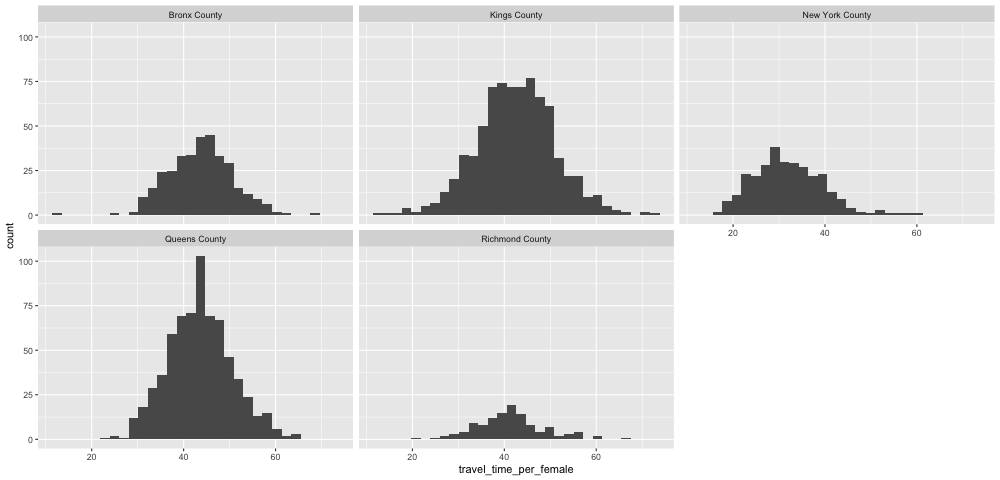

In [101]:
%%R -w 1000

nyc_census_data %>%
    ggplot(aes(x = travel_time_per_female)) +
    geom_histogram() +
    facet_wrap(~borough)


# your code here. refer to example notebooks for help


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 110 rows containing non-finite outside the scale range
(`stat_boxplot()`). 

R[write to console]: 2: Removed 110 rows containing missing values or values outside the scale range
(`geom_point()`). 



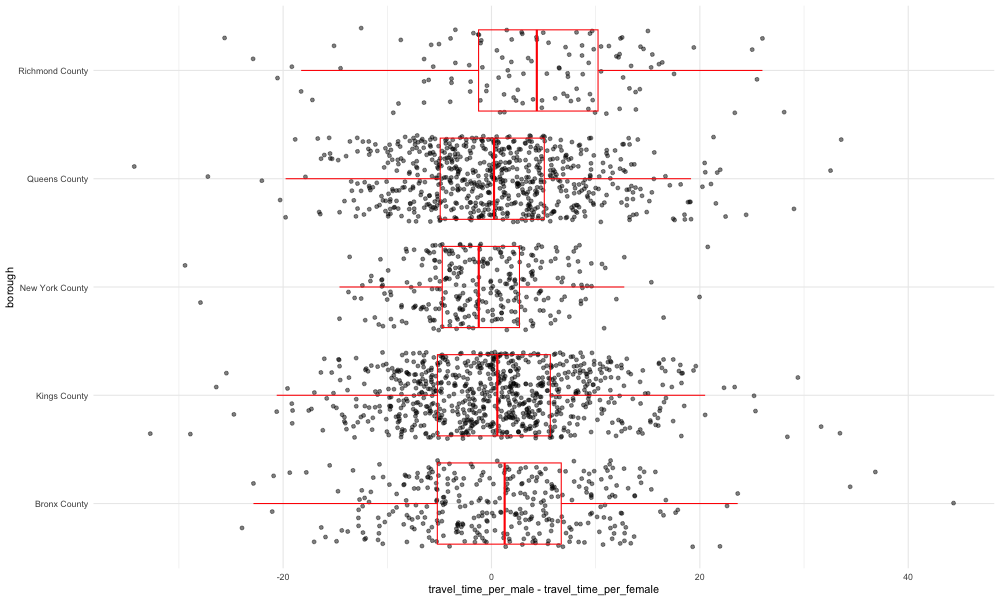

In [106]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=travel_time_per_male -travel_time_per_female, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") +
    theme_minimal()

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

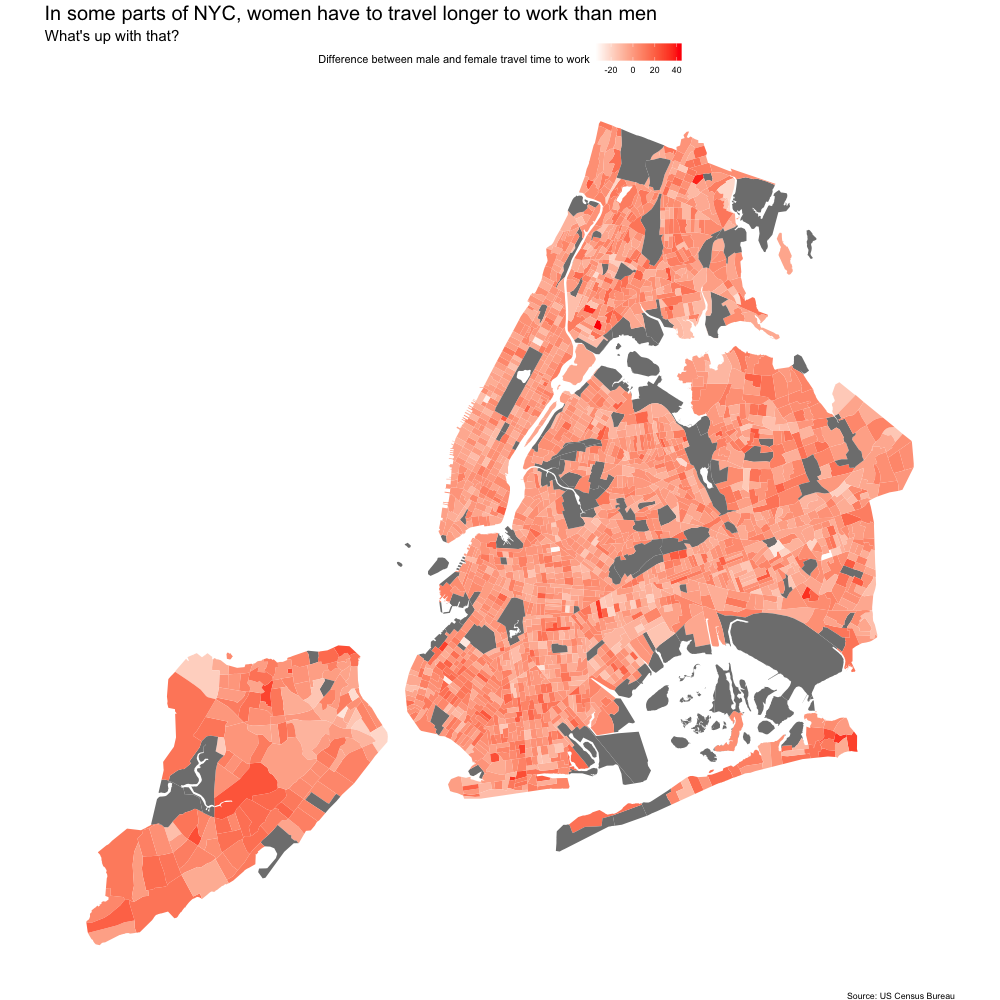

In [105]:
%%R -w 1000 -h 1000


nyc_census_data %>%
  ggplot(aes(fill = travel_time_per_male -travel_time_per_female)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red", name = "Difference between male and female travel time to work") + 
  theme_minimal() +
  labs(
    title = "In some parts of NYC, women have to travel longer to work than men",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  ) +
theme_void() +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top"
  )
# your code here. refer to example notebooks for help
